# Preprocessing of the CPDB network
Refer to the work of EMOGI [LINK](https://github.com/schulter/EMOGI/tree/master).
In this notebook, I want to collect the protein-protein-interaction (PPI) network from ConsensusPathDB and preprocess it.
The preprocessing contains the following steps:
* Filter out "complex" interactions (more than two partners)
* Filter out interactions with score <= 0.5
* Convert the resulting edgelist to an adjacency matrix
* Export the edgelist to .sif (can be read by cytoscape directly)

I downloaded the CPDB network from [here](http://cpdb.molgen.mpg.de/download/ConsensusPathDB_human_PPI.gz) on the 12th of January 2024.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import networkx as nx
import seaborn as sns
%matplotlib inline

In [30]:
interactions = pd.read_csv('ConsensusPathDB_human_PPI.12012024.gz',
                           compression='gzip',
                           header=1,
                           sep='\t',
                           encoding='utf8'
                          )
interactions_nona = interactions.dropna()
interactions_nona

#  source_databases  \
8        PhosphoPOINT,Reactome,HPRD,Spike,Biogrid   
9              HPRD,Reactome,PhosphoPOINT,Biogrid   
24                            DIP,Reactome,IntAct   
25                                  Reactome,HPRD   
26      BIND,HPRD,CORUM,MIPS-MPPI,Reactome,IntAct   
...                                           ...   
554466                              Manual upload   
554467                              Manual upload   
554468                              Manual upload   
554469                              Manual upload   
554470                              Manual upload   

                            interaction_publications  \
8                          1660465,16713569,12547834   
9                   1660465,12709393,1672777,1309330   
24      22210847,17486119,21408196,16906149,19897728   
25                                          11591728   
26                         10093054,9831708,23587463   
...                                              ...   
554466                              16099987,8868471   
554467                              16099987,7716514   
554468                              16099987,7615553   
554469                             12820960,16099987   
554470                             16099987,11433294   

       interaction_participants__uniprot_entry  \
8                        ANPRA_HUMAN,ANF_HUMAN   
9                       ANFC_HUMAN,ANPRB_HUMAN   
24                     STIM1_HUMAN,TRPC1_HUMAN   
25                      AT2B4_HUMAN,NOS1_HUMAN   
26                     ABCC9_HUMAN,KCJ11_HUMAN   
...                                        ...   
554466                 PI42A_HUMAN,RHG01_HUMAN   
554467                   FIBA_HUMAN,ITB1_HUMAN   
554468                  CREB1_HUMAN,TF2B_HUMAN   
554469                  MTOR_HUMAN,4EBP3_HUMAN   
554470                   PAR1_HUMAN,DVL1_HUMAN   

       interaction_participants__uniprot_id  \
8                             P16066,P01160   
9                             P23582,P20594   
24                            Q13586,P48995   
25                            P23634,P29475   
26                            O60706,Q14654   
...                                     ...   
554466                        P48426,Q07960   
554467                        P02671,P05556   
554468                        P16220,Q00403   
554469                        P42345,O60516   
554470                        P25116,O14640   

       interaction_participants__genename interaction_participants__hgnc_id  \
8                               NPR1,NPPA               HGNC:7943,HGNC:7939   
9                               NPPC,NPR2               HGNC:7941,HGNC:7944   
24                            STIM1,TRPC1             HGNC:11386,HGNC:12333   
25                            ATP2B4,NOS1                HGNC:817,HGNC:7872   
26                           ABCC9,KCNJ11                 HGNC:60,HGNC:6257   
...                                   ...                               ...   
554466                    PIP4K2A,ARHGAP1                HGNC:8997,HGNC:673   
554467                          FGA,ITGB1               HGNC:3661,HGNC:6153   
554468                        CREB1,GTF2B               HGNC:2345,HGNC:4648   
554469                      MTOR,EIF4EBP3               HGNC:3942,HGNC:3290   
554470                           F2R,DVL1               HGNC:3537,HGNC:3084   

       interaction_participants__entrez_gene  \
8                                  4881,4878   
9                                  4880,4882   
24                                 6786,7220   
25                                  493,4842   
26                                10060,3767   
...                                      ...   
554466                              5305,392   
554467                             2243,3688   
554468                             1385,2959   
554469                             2475,8637   
554470                             2149,1855   

       interaction_participa

(521150, 9)

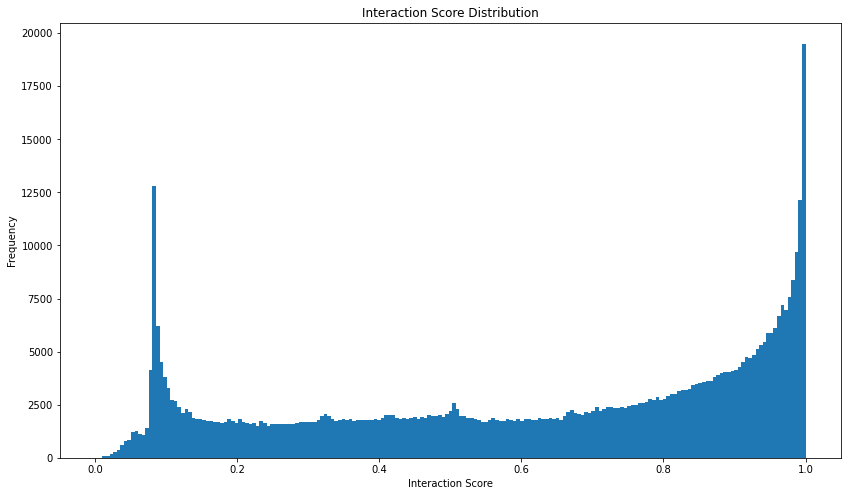

In [31]:
bins = np.linspace(0, 1, 200)
fig = plt.figure(figsize=(14, 8))
ax = plt.hist(interactions_nona.interaction_confidence, bins)
plt.xlabel('Interaction Score')
plt.ylabel('Frequency')
plt.title('Interaction Score Distribution')
interactions_nona.shape

### Remove "complex" interactions & low confidence

In [33]:
# select interactions with exactly two partners
binary_inter = interactions_nona[interactions_nona.interaction_participants__genename.str.count(',') == 1]
# split the interactions columns into interaction partners
edgelist = pd.concat([binary_inter.interaction_participants__genename.str.split(',', expand=True),
                                binary_inter.interaction_confidence], axis=1
                              )
# make the dataframe beautiful
edgelist.set_index([np.arange(edgelist.shape[0])], inplace=True)
edgelist.columns = ['partner1', 'partner2', 'confidence']

# select interactions with confidence score above threshold
high_conf_edgelist = edgelist[edgelist.confidence > .5]
edgelist.head()

partner1 partner2  confidence
0     NPR1     NPPA    0.192576
1     NPPC     NPR2    0.230184
2    STIM1    TRPC1    0.597177
3   ATP2B4     NOS1    0.520836
4    ABCC9   KCNJ11    0.990732

In [34]:
interactions.shape, interactions_nona.shape, edgelist.shape, high_conf_edgelist.shape

((554471, 9), (521150, 9), (521150, 3), (333503, 3))

In [35]:
high_conf_edgelist

partner1  partner2  confidence
2         STIM1     TRPC1    0.597177
3        ATP2B4      NOS1    0.520836
4         ABCC9    KCNJ11    0.990732
5         HADHB     HADHA    0.999980
6        GTF2E1    GTF2E2    0.973170
...         ...       ...         ...
521144   CAMKK2     CALM3    0.662630
521146      FGA     ITGB1    0.994544
521147    CREB1     GTF2B    0.998347
521148     MTOR  EIF4EBP3    0.801299
521149      F2R      DVL1    0.941436

[333503 rows x 3 columns]

In [36]:
# Describe the data.
high_conf_edgelist.describe()

confidence
count  333503.000000
mean        0.825607
std         0.147069
min         0.500007
25%         0.716427
50%         0.864133
75%         0.955483
max         1.000000

### Construct Adjacency Matrix
* filter out duplicate and selfloop edges

In [37]:
# Multiple edges of a graph are automatically removed by networkx.(interactions: 333503-->333107)
G = nx.from_pandas_edgelist(df=high_conf_edgelist, source='partner1', target='partner2', edge_attr='confidence')
# Remove the self-looping edges.(interacions: 333107-->333105)
G.remove_edges_from(nx.selfloop_edges(G))
adj_pd = nx.to_pandas_adjacency(G)
adjacency_matrix = adj_pd.values
node_names = adj_pd.index.values

avg_node_degree = np.mean([value for key, value in G.degree()])
print ("Constructed Adjacency Matrix with average node degree of: {}".format(avg_node_degree))
print ("Adjacency matrix has {} edges and {} nodes in total".format(G.number_of_edges(), G.number_of_nodes()))

Constructed Adjacency Matrix with average node degree of: 46.982369534555716
Adjacency matrix has 333105 edges and 14180 nodes in total


In [38]:
adj_pd

STIM1  TRPC1  ATP2B4  NOS1  ABCC9  KCNJ11  HADHB  HADHA  GTF2E1  \
STIM1        0.0    1.0     1.0   0.0    0.0     0.0    0.0    0.0     0.0   
TRPC1        1.0    0.0     0.0   0.0    0.0     0.0    0.0    0.0     0.0   
ATP2B4       1.0    0.0     0.0   1.0    0.0     0.0    0.0    0.0     0.0   
NOS1         0.0    0.0     1.0   0.0    0.0     0.0    0.0    0.0     0.0   
ABCC9        0.0    0.0     0.0   0.0    0.0     1.0    0.0    0.0     0.0   
...          ...    ...     ...   ...    ...     ...    ...    ...     ...   
GPR153       0.0    0.0     0.0   0.0    0.0     0.0    0.0    0.0     0.0   
HDC          0.0    0.0     0.0   0.0    0.0     0.0    0.0    0.0     0.0   
CSMD1        0.0    0.0     0.0   0.0    0.0     0.0    0.0    0.0     0.0   
GABARAPL3    0.0    0.0     0.0   0.0    0.0     0.0    0.0    0.0     0.0   
PPP1R1A      0.0    0.0     0.0   0.0    0.0     0.0    0.0    0.0     0.0   

           GTF2E2  ...  LAIR1  CRIM1  ADGRG6  NPPC  SIRPB2  GPR153  HDC  \
STIM1         0.0  ...    0.0    0.0     0.0   0.0     0.0     0.0  0.0   
TRPC1         0.0  ...    0.0    0.0     0.0   0.0     0.0     0.0  0.0   
ATP2B4        0.0  ...    0.0    0.0     0.0   0.0     0.0     0.0  0.0   
NOS1          0.0  ...    0.0    0.0     0.0   0.0     0.0     0.0  0.0   
ABCC9         0.0  ...    0.0    0.0     0.0   0.0     0.0     0.0  0.0   
...           ...  ...    ...    ...     ...   ...     ...     ...  ...   
GPR153        0.0  ...    0.0    0.0     0.0   0.0     0.0     0.0  0.0   
HDC           0.0  ...    0.0    0.0     0.0   0.0     0.0     0.0  0.0   
CSMD1         0.0  ...    0.0    0.0     0.0   0.0     0.0     0.0  0.0   
GABARAPL3     0.0  ...    0.0    0.0     0.0   0.0     0.0     0.0  0.0   
PPP1R1A       0.0  ...    0.0    0.0     0.0   0.0     0.0     0.0  0.0   

           CSMD1  GABARAPL3  PPP1R1A  
STIM1        0.0        0.0      0.0  
TRPC1        0.0        0.0      0.0  
ATP2B4       0.0        0.0      0.0  
NOS1         0.0        0.0      0.0  
ABCC9        0.0        0.0      0.0  
...          ...        ...      ...  
GPR153       0.0        0.0      0.0  
HDC          0.0        0.0      0.0  
CSMD1        0.0        0.0      0.0  
GABARAPL3    0.0        0.0      0.0  
PPP1R1A      0.0        0.0      0.0  

[14180 rows x 14180 columns]

In [39]:
G.edges,G.number_of_edges()

(EdgeView([('STIM1', 'TRPC1'), ('STIM1', 'FGFR3'), ('STIM1', 'CRACR2A'), ('STIM1', 'RSL1D1'), ('STIM1', 'ORAI1'), ('STIM1', 'PPIB'), ('STIM1', 'STIM2'), ('STIM1', 'IFNGR1'), ('STIM1', 'PPIA'), ('STIM1', 'KAT5'), ('STIM1', 'ORAI3'), ('STIM1', 'SETDB1'), ('STIM1', 'RABAC1'), ('STIM1', 'INSIG2'), ('STIM1', 'MAPRE1'), ('STIM1', 'UBQLN1'), ('STIM1', 'ATP2C1'), ('STIM1', 'ATP2B4'), ('STIM1', 'PDIA3'), ('STIM1', 'SARAF'), ('STIM1', 'EXOC5'), ('STIM1', 'GRIN2C'), ('STIM1', 'YWHAG'), ('STIM1', 'OPTN'), ('STIM1', 'ORAI2'), ('STIM1', 'CAV1'), ('STIM1', 'JUN'), ('STIM1', 'TRPV4'), ('STIM1', 'PRKAA2'), ('STIM1', 'SEPTIN11'), ('STIM1', 'S100A16'), ('STIM1', 'SEC22B'), ('STIM1', 'CAT'), ('STIM1', 'SF1'), ('STIM1', 'HLA-DRA'), ('STIM1', 'HEXB'), ('STIM1', 'TCTN2'), ('STIM1', 'EVC2'), ('STIM1', 'TMEM17'), ('STIM1', 'TMEM216'), ('STIM1', 'CDH1'), ('STIM1', 'PTPRN2'), ('STIM1', 'HAUS1'), ('STIM1', 'LRRTM1'), ('STIM1', 'IL17RB'), ('STIM1', 'CD1E'), ('STIM1', 'EGLN3'), ('STIM1', 'EFTUD2'), ('STIM1', 'RNF4'

In [40]:
G.degree()

DegreeView({'STIM1': 72, 'TRPC1': 18, 'ATP2B4': 43, 'NOS1': 38, 'ABCC9': 2, 'KCNJ11': 15, 'HADHB': 262, 'HADHA': 287, 'GTF2E1': 52, 'GTF2E2': 92, 'GTF2A1': 54, 'GTF2A2': 12, 'SCRIB': 98, 'VANGL2': 35, 'PARD6A': 62, 'DVL2': 167, 'MAFK': 29, 'BACH1': 51, 'GAB1': 90, 'GRB2': 854, 'PIK3R1': 369, 'PIK3CA': 117, 'SRC': 522, 'PXN': 236, 'CLPS': 2, 'PNLIP': 3, 'GNGT1': 9, 'GNB1': 132, 'CNGA1': 2, 'CNGB1': 2, 'FNTA': 30, 'FNTB': 39, 'MRE11': 167, 'RAD50': 144, 'KPNA2': 263, 'NBN': 118, 'KAT5': 326, 'ATM': 192, 'SMARCA5': 179, 'BAZ1B': 81, 'UBE2I': 505, 'SUMO1': 227, 'UBE2V2': 54, 'UBE2N': 171, 'BRCA1': 980, 'BARD1': 258, 'SUMO2': 464, 'MDC1': 300, 'HERC2': 274, 'ATR': 116, 'ATRIP': 45, 'TIPIN': 15, 'TIMELESS': 31, 'PPP4R2': 45, 'PPP4C': 63, 'XRCC3': 104, 'RAD51C': 18, 'EME2': 5, 'MUS81': 26, 'EME1': 24, 'RAD51': 157, 'BRCA2': 129, 'SLX4': 43, 'SLX1A.SLX1B': 7, 'ERCC4': 37, 'ERCC1': 34, 'LIG3': 72, 'XRCC1': 81, 'XRCC6': 588, 'XRCC5': 310, 'XRCC4': 43, 'LIG4': 89, 'HBA1.HBA2': 70, 'HBB': 39, 'SOS

In [42]:
high_conf_edgelist_no_repeat = nx.to_pandas_edgelist(G)
high_conf_edgelist_no_repeat.columns=['partner1','partner2','confidence'] # rename columns names
high_conf_edgelist_no_repeat.to_csv('CPDB_symbols_high_conf_edgelist_no_repeat.tsv', sep='\t',
                                   index=False)

high_conf_edgelist_no_repeat

partner1 partner2  confidence
0         STIM1    TRPC1    0.597177
1         STIM1    FGFR3    0.994840
2         STIM1  CRACR2A    0.632207
3         STIM1   RSL1D1    0.761169
4         STIM1    ORAI1    0.917917
...         ...      ...         ...
333100   ZNF221   ZNF225    0.718413
333101    WDR18    DDX60    0.503814
333102    PRSS8  SLC13A1    0.560480
333103  CCDC187    MSS51    0.507415
333104    ITIH6   SMIM29    0.935006

[333105 rows x 3 columns]

D:\devtool\Anaconda3\envs\EMOGI-tf\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Node Degree Distribution of Genes in PPI')

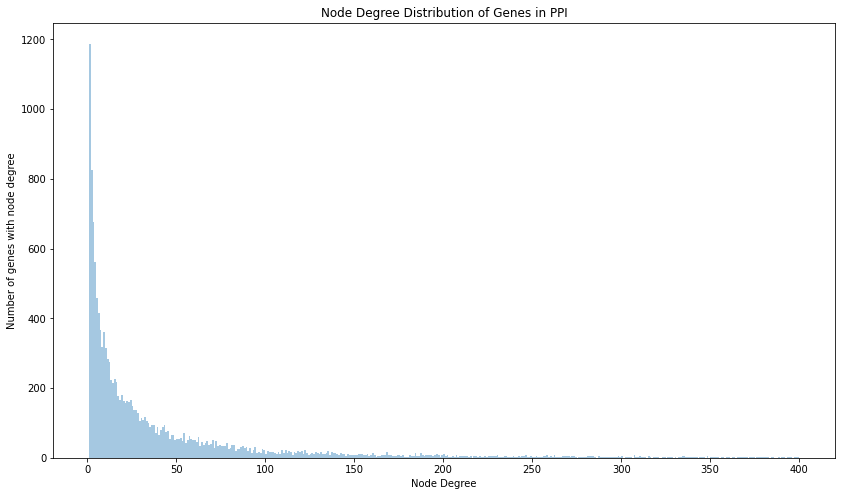

In [43]:
node_degrees = np.array([i[1] for i in list(G.degree())])
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(1, 400, 400)

sns.distplot(node_degrees, kde=False, bins=bins) 

#ax = plt.hist(node_degrees, bins)
plt.xlabel('Node Degree')
plt.ylabel('Number of genes with node degree')
plt.title('Node Degree Distribution of Genes in PPI')

In [44]:
df=pd.DataFrame(node_degrees,columns=['node degree'])
df.describe().astype(int)

node degree
count        14180
mean            46
std             90
min              1
25%              5
50%             17
75%             50
max           1650